###### Imports

In [1]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary
from datetime import datetime, timedelta

# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Wed Apr 20 10:09:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

###### Re-Format Time and Dataset Manupiulation

In [2]:
def get_time_format(seconds):
    sec = timedelta(seconds=int(seconds))
    d = datetime(1, 1, 1) + sec
    if d.day-1 == 1:
        return "%.2d:%.2d:%.2d:%.2d" % (d.day-1, d.hour, d.minute, d.second)
    return "%.2d:%.2d:%.2d" % (d.hour, d.minute, d.second)


def calculate_time(start_time):
    return get_time_format(time.time() - start_time)

In [3]:
transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [4]:
mnist_data_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw



In [5]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))

Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [6]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


In [7]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='gray') # convert from tensor to image

In [8]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    data = data.numpy()

    target = dataset.targets[i]
    target = target.numpy()
    imshow(data)
    axis.set_title(target)

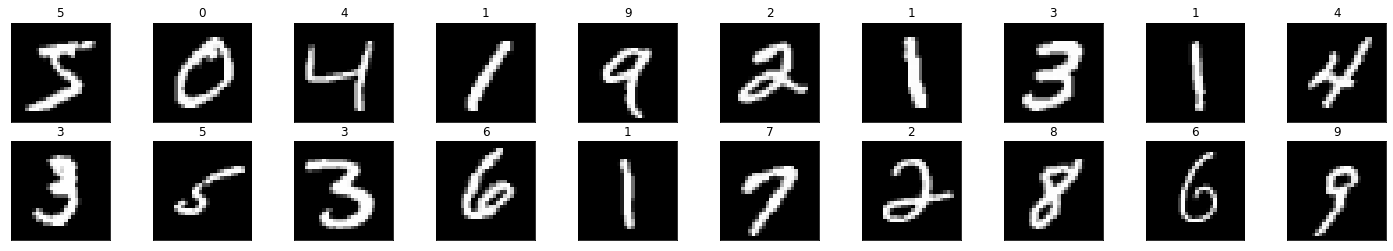

In [9]:
visualize(mnist_data_train)

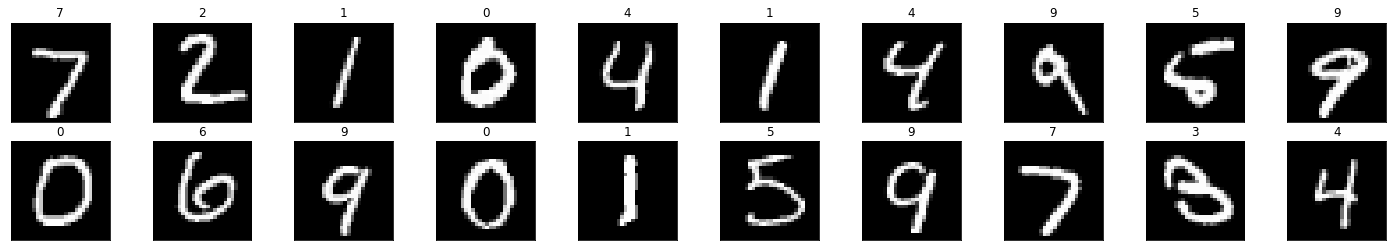

In [10]:
visualize(mnist_data_test)

###### Partitioning the Data (IID and non-IID)

In [11]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [12]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict

###### Models

In [13]:
class MNIST_2NN(nn.Module):
  """
  A multilayer-perceptron with 2-hidden layers with 200 units each
  using ReLu activations

  Total Expected Params: 199,210
  """
  def __init__(self):
    super(MNIST_2NN, self).__init__()

    self.fc1 = nn.Linear(28*28, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)

    return x

In [14]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

Print Model Summaries

In [15]:
mnist_mlp = MNIST_2NN()
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_mlp.cuda()
  mnist_cnn.cuda()

print("MNIST MLP SUMMARY")
print(summary(mnist_mlp, (28,28)))

print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28,28)))

MNIST MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                  [-1, 200]          40,200
            Linear-3                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------
None

MNIST CNN SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264

###### Testing Loop

In [16]:
def testing(model, dataset, bs, criterion, num_classes, classes):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  # print("Test Loss: {:.6f}\n".format(test_loss))

  # print test accuracy
  # for i in range(10):
  #   if total_class[i]>0:
  #     print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
  #           (classes[i], 100 * correct_class[i] / total_class[i],
  #           np.sum(correct_class[i]), np.sum(total_class[i])))
  #   else:
  #     print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  test_accuracy = 100. * np.sum(correct_class) / np.sum(total_class)

  # print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
  #       100. * np.sum(correct_class) / np.sum(total_class),
  #       np.sum(correct_class), np.sum(total_class)))
  return test_loss, test_accuracy

###### FedProx

Systems Heterogeneity Simulations

Generate epochs for selected clients based on percentage of devices that corresponds to heterogeneity.
Assign x number of epochs (chosen unifirmly at random between [1, E]) to 0%, 50% or 90% of the selected devices, respectively. Settings where 0% devices perform fewer than E epochs of work correspond to the environments without system heterogeneity, while 90% of the devices sending their partial solutions corresponds to highly heterogenous system.

In [17]:
def GenerateLocalEpochs(percentage, size, max_epochs):
  ''' Method generates list of epochs for selected clients
  to replicate system heteroggeneity

  Params:
    percentage: percentage of clients to have fewer than E epochs
    size:       total size of the list
    max_epochs: maximum value for local epochs
  
  Returns:
    List of size epochs for each Client Update

  '''

  # if percentage is 0 then each client runs for E epochs
  if percentage == 0:
      return np.array([max_epochs]*size)
  else:
    # get the number of clients to have fewer than E epochs
    heterogenous_size = int((percentage/100) * size)

    # generate random uniform epochs of heterogenous size between 1 and E
    epoch_list = np.random.randint(1, max_epochs, heterogenous_size)

    # the rest of the clients will have E epochs
    remaining_size = size - heterogenous_size
    rem_list = [max_epochs]*remaining_size

    epoch_list = np.append(epoch_list, rem_list, axis=0)
    
    # shuffle the list and return
    np.random.shuffle(epoch_list)

    return epoch_list

###### Local Training (Client Update)

Local training for the model on client side

In [18]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs, mu, algorithm):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)
    self.algorithm = algorithm
    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):
    # print("Client training for {} epochs.".format(self.epochs))
    criterion = nn.CrossEntropyLoss()
    proximal_criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)

    # use the weights of global model for proximal term calculation
    global_model = copy.deepcopy(model)

    # calculate local training time
    start_time = time.time()


    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)

        # calculate the loss + the proximal term
        _, pred = torch.max(output, 1)

        if self.algorithm == 'fedprox':
          proximal_term = 0.0

          # iterate through the current and global model parameters
          for w, w_t in zip(model.parameters(), global_model.parameters()) :
            # update the proximal term 
            #proximal_term += torch.sum(torch.abs((w-w_t)**2))
            proximal_term += (w-w_t).norm(2)

          loss = criterion(output, labels) + (mu/2)*proximal_term
        else:
          loss = criterion(output, labels)
    
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss, (time.time() - start_time)

###### Server Side Training
Following Algorithm 1 from the paper

In [19]:
def training(model, rounds, batch_size, lr, ds, data_dict, test_data_dict, C, K, E, mu, percentage, plt_title, plt_color, target_test_accuracy, algorithm="fedprox"):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - test_data_dict:  Data used for testing the model
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - mu:              proximal term constant
    - percentage:      percentage of selected client to have fewer than E epochs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []

  # test accuracy
  test_acc = []

  # store last loss for convergence
  last_loss = 0.0

  # total time taken 
  total_time = 0

  print(f"System heterogeneity set to {percentage}% stragglers.\n")
  print(f"Picking {max(int(C*K),1 )} random clients per round.\n")

  for curr_round in range(1, rounds+1):
    w, local_loss, lst_local_train_time = [], [], []

    m = max(int(C*K), 1)

    heterogenous_epoch_list = GenerateLocalEpochs(percentage, size=m, max_epochs=E)
    heterogenous_epoch_list = np.array(heterogenous_epoch_list)

    S_t = np.random.choice(range(K), m, replace=False)
    S_t = np.array(S_t)
    
    # For Federated Averaging, drop all the clients that are stragglers
    if algorithm == 'fedavg':
      stragglers_indices = np.argwhere(heterogenous_epoch_list < E)
      heterogenous_epoch_list = np.delete(heterogenous_epoch_list, stragglers_indices)
      S_t = np.delete(S_t, stragglers_indices)

    for k, epoch in zip(S_t, heterogenous_epoch_list):
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=epoch, idxs=data_dict[k], mu=mu, algorithm=algorithm)
      weights, loss, local_train_time = local_update.train(model=copy.deepcopy(model))

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      lst_local_train_time.append(local_train_time)

    # calculate time to update the global weights
    global_start_time = time.time()

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    global_end_time = time.time()

    # calculate total time 
    total_time += (global_end_time - global_start_time) + sum(lst_local_train_time)/len(lst_local_train_time)

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)

    # test accuracy
    criterion = nn.CrossEntropyLoss()
    test_loss, test_accuracy = testing(model, test_data_dict, 128, criterion, num_classes, classes_test)
    


    print(f"Round: {curr_round}... \tAverage Train Loss: {round(loss_avg, 3)}... \tTest Loss: {test_loss}... \tTest Accuracy: {test_accuracy}")
    train_loss.append(loss_avg)

    test_acc.append(test_accuracy)
    # break if we achieve the target test accuracy
    if test_accuracy >= target_test_accuracy:
      rounds = curr_round
      break

    # break if we achieve convergence, i.e., loss between two consecutive rounds is <0.0001
    if algorithm == 'fedprox' and abs(loss_avg - last_loss) < 0.0001:
      rounds = curr_round
      break
    
    # update the last loss
    last_loss = loss_avg

  # plot train loss
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'.jpg', format='jpg')

  # plot test accuracy
  fig1, ax1 = plt.subplots()
  x_axis1 = np.arange(1, rounds+1)
  y_axis1 = np.array(test_acc)
  ax1.plot(x_axis1, y_axis1)

  ax1.set(xlabel='Number of Rounds', ylabel='Test Accuracy', title=plt_title)
  ax1.grid()
  fig1.savefig(plt_title+'-test.jpg', format='jpg')
  
  print("Training Done!")
  #print("Total time taken to Train: {}".format(get_time_format(total_time)))

  return model 

###### Special Case of FedProx with mu = 0 where it is Federated Averaging(IId)

> Train

System heterogeneity set to 0% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.152... 	Test Loss: 0.14566898895055055... 	Test Accuracy: 96.70886075949367
Round: 2... 	Average Train Loss: 0.032... 	Test Loss: 0.11243197723790072... 	Test Accuracy: 97.46835443037975
Round: 3... 	Average Train Loss: 0.019... 	Test Loss: 0.08873573350275402... 	Test Accuracy: 97.9746835443038
Round: 4... 	Average Train Loss: 0.016... 	Test Loss: 0.07684068786231801... 	Test Accuracy: 97.84810126582279
Round: 5... 	Average Train Loss: 0.013... 	Test Loss: 0.07012975297132507... 	Test Accuracy: 98.22784810126582
Round: 6... 	Average Train Loss: 0.013... 	Test Loss: 0.061606690894615894... 	Test Accuracy: 98.35443037974683
Training Done!


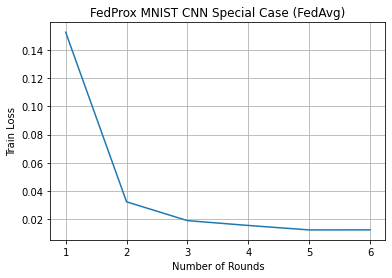

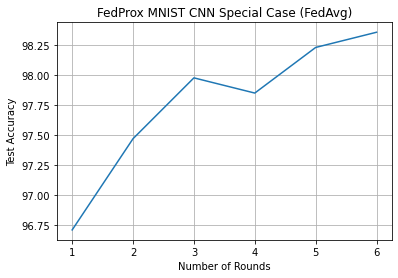

In [ ]:
## 1
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03 #changed learning rate from 0.01 to 0.03
# proximal term constant
mu = 0.0
# percentage of clients to have fewer than E epochs
percentage = 0
# target test accuracy
target_test_accuracy=99.0
# data partition dictionary
iid_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, iid_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN Special Case (FedAvg)", "orange", target_test_accuracy)

###### Training with 0% probability of system heterogeneity

> MNIST CNN on IID

> Train

System heterogeneity set to 0% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.202... 	Test Loss: 0.1485364259839058... 	Test Accuracy: 95.56962025316456
Round: 2... 	Average Train Loss: 0.057... 	Test Loss: 0.11141499745624606... 	Test Accuracy: 97.0886075949367
Round: 3... 	Average Train Loss: 0.041... 	Test Loss: 0.09468160586030572... 	Test Accuracy: 97.0886075949367
Round: 4... 	Average Train Loss: 0.035... 	Test Loss: 0.08206961950687691... 	Test Accuracy: 97.72151898734177
Round: 5... 	Average Train Loss: 0.032... 	Test Loss: 0.07066218836399203... 	Test Accuracy: 97.9746835443038
Round: 6... 	Average Train Loss: 0.031... 	Test Loss: 0.06523932652630829... 	Test Accuracy: 97.9746835443038
Round: 7... 	Average Train Loss: 0.028... 	Test Loss: 0.06291763313941992... 	Test Accuracy: 98.35443037974683
Round: 8... 	Average Train Loss: 0.027... 	Test Loss: 0.054884011427599036... 	Test Accuracy: 98.60759493670886
Round: 9... 	Average Train Loss: 0

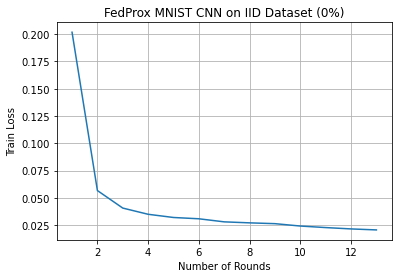

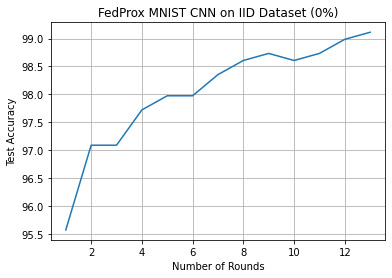

In [ ]:
## 2
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 0
# target_test_accuracy
target_test_accuracy=99.0
# data partition dictionary
iid_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, iid_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN on IID Dataset (0%)", "orange", target_test_accuracy)

MNIST CNN on Non IID

Train

System heterogeneity set to 0% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.04... 	Test Loss: 2.3015445671081545... 	Test Accuracy: 14.683544303797468
Round: 2... 	Average Train Loss: 0.031... 	Test Loss: 2.035690001678467... 	Test Accuracy: 24.556962025316455
Round: 3... 	Average Train Loss: 0.018... 	Test Loss: 1.314469492149353... 	Test Accuracy: 44.43037974683544
Round: 4... 	Average Train Loss: 0.017... 	Test Loss: 1.4575675086975097... 	Test Accuracy: 57.848101265822784
Round: 5... 	Average Train Loss: 0.018... 	Test Loss: 0.8400270995140076... 	Test Accuracy: 72.27848101265823
Round: 6... 	Average Train Loss: 0.017... 	Test Loss: 0.5890313675880432... 	Test Accuracy: 74.68354430379746
Round: 7... 	Average Train Loss: 0.02... 	Test Loss: 0.6683296169281006... 	Test Accuracy: 74.9367088607595
Round: 8... 	Average Train Loss: 0.015... 	Test Loss: 0.37596991477012637... 	Test Accuracy: 89.24050632911393
Round: 9... 	Average Train Loss: 0.012.

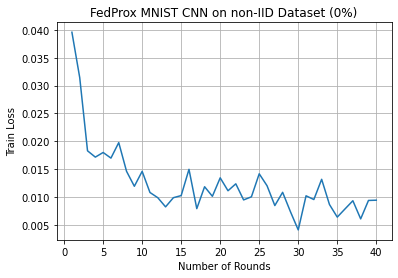

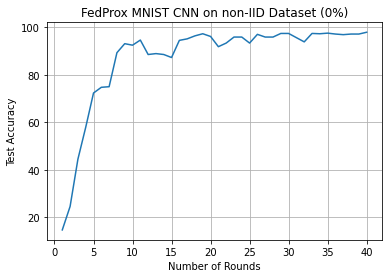

In [ ]:
## 3
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 0

# target_test_accuracy
target_test_accuracy=99.0
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_non_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN on non-IID Dataset (0%)", "green", target_test_accuracy)


MNIST MLP on IID

Train

System heterogeneity set to 0% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.244... 	Test Loss: 0.3376686584055424... 	Test Accuracy: 90.63291139240506
Round: 2... 	Average Train Loss: 0.058... 	Test Loss: 0.30346925128549335... 	Test Accuracy: 92.65822784810126
Round: 3... 	Average Train Loss: 0.052... 	Test Loss: 0.266900432407856... 	Test Accuracy: 93.79746835443038
Round: 4... 	Average Train Loss: 0.039... 	Test Loss: 0.24031720412001015... 	Test Accuracy: 93.92405063291139
Round: 5... 	Average Train Loss: 0.037... 	Test Loss: 0.21592705222377553... 	Test Accuracy: 94.81012658227849
Training Done!


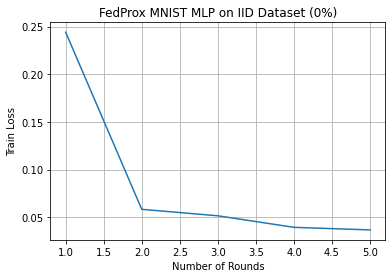

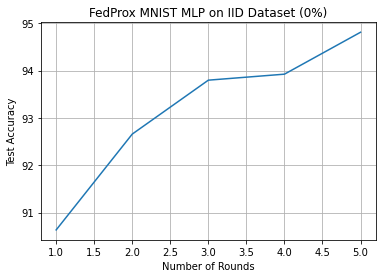

In [22]:
## 4
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each round
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 0
# target_test_accuracy
target_test_accuracy=94.0
# dict containing different type of data partition
data_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST MLP on IID Dataset (0%)", "orange", target_test_accuracy)

MNIST MLP on Non IID

Train

System heterogeneity set to 0% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.046... 	Test Loss: 3.2816867961883545... 	Test Accuracy: 31.0126582278481
Round: 2... 	Average Train Loss: 0.03... 	Test Loss: 2.398630335998535... 	Test Accuracy: 33.79746835443038
Round: 3... 	Average Train Loss: 0.022... 	Test Loss: 1.6355698434829713... 	Test Accuracy: 51.139240506329116
Round: 4... 	Average Train Loss: 0.017... 	Test Loss: 1.700880606842041... 	Test Accuracy: 60.0
Round: 5... 	Average Train Loss: 0.024... 	Test Loss: 1.2278579393386841... 	Test Accuracy: 63.29113924050633
Round: 6... 	Average Train Loss: 0.023... 	Test Loss: 0.8096841857910156... 	Test Accuracy: 72.40506329113924
Round: 7... 	Average Train Loss: 0.016... 	Test Loss: 0.5415734886169433... 	Test Accuracy: 83.41772151898734
Round: 8... 	Average Train Loss: 0.017... 	Test Loss: 0.4505783570766449... 	Test Accuracy: 86.07594936708861
Round: 9... 	Average Train Loss: 0.015... 	Test Loss: 

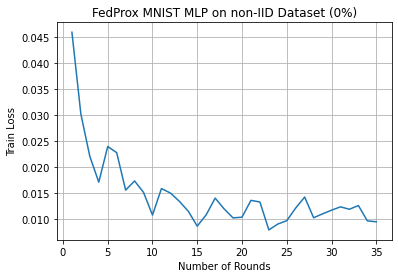

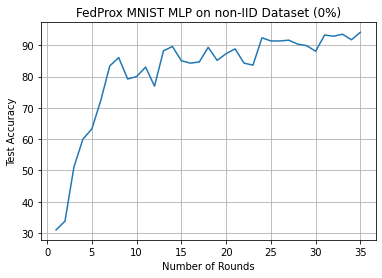

In [23]:
## 5
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 0
# target_test_accuracy
target_test_accuracy=94.0
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_non_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST MLP on non-IID Dataset (0%)", "green", target_test_accuracy)

###### Training with 50% probability of system heterogeneity

> MNIST CNN on IID

> Train

System heterogeneity set to 50% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.209... 	Test Loss: 0.1410120943903923... 	Test Accuracy: 95.69620253164557
Round: 2... 	Average Train Loss: 0.074... 	Test Loss: 0.10975932618184016... 	Test Accuracy: 96.45569620253164
Round: 3... 	Average Train Loss: 0.059... 	Test Loss: 0.08794213238038938... 	Test Accuracy: 97.46835443037975
Round: 4... 	Average Train Loss: 0.038... 	Test Loss: 0.08416109302703116... 	Test Accuracy: 97.72151898734177
Round: 5... 	Average Train Loss: 0.037... 	Test Loss: 0.07215178844446782... 	Test Accuracy: 98.10126582278481
Round: 6... 	Average Train Loss: 0.045... 	Test Loss: 0.06625538594309183... 	Test Accuracy: 98.22784810126582
Round: 7... 	Average Train Loss: 0.029... 	Test Loss: 0.059944341990593966... 	Test Accuracy: 97.9746835443038
Round: 8... 	Average Train Loss: 0.048... 	Test Loss: 0.055031884974144483... 	Test Accuracy: 98.10126582278481
Round: 9... 	Average Train Lo

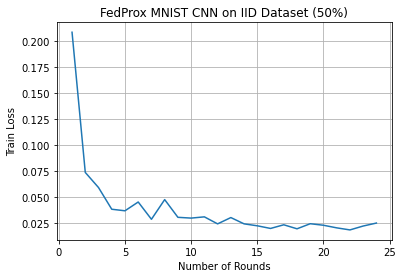

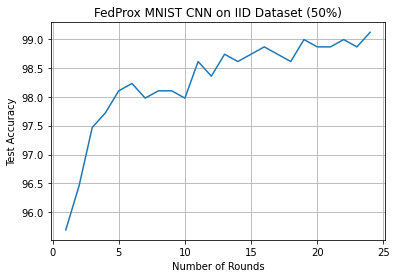

In [ ]:
## 6
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 50
# target_test_accuracy
target_test_accuracy=99.0
# data partition dictionary
iid_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, iid_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN on IID Dataset (50%)", "orange", target_test_accuracy)

**MNIST CNN on Non IID**

**Train**

System heterogeneity set to 50% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.051... 	Test Loss: 2.072066396331787... 	Test Accuracy: 24.556962025316455
Round: 2... 	Average Train Loss: 0.036... 	Test Loss: 1.726231941986084... 	Test Accuracy: 44.177215189873415
Round: 3... 	Average Train Loss: 0.032... 	Test Loss: 1.4770271869659424... 	Test Accuracy: 54.43037974683544
Round: 4... 	Average Train Loss: 0.026... 	Test Loss: 1.0017017345428467... 	Test Accuracy: 62.0253164556962
Round: 5... 	Average Train Loss: 0.026... 	Test Loss: 0.8675530115127563... 	Test Accuracy: 69.74683544303798
Round: 6... 	Average Train Loss: 0.025... 	Test Loss: 0.6877597781181335... 	Test Accuracy: 75.82278481012658
Round: 7... 	Average Train Loss: 0.024... 	Test Loss: 0.6389925252914429... 	Test Accuracy: 78.48101265822785
Round: 8... 	Average Train Loss: 0.034... 	Test Loss: 0.44186791243553164... 	Test Accuracy: 87.59493670886076
Round: 9... 	Average Train Loss: 0.01

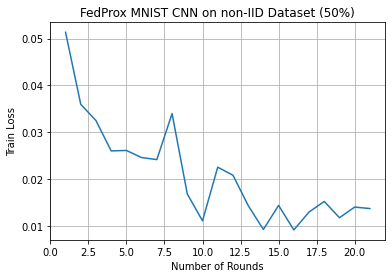

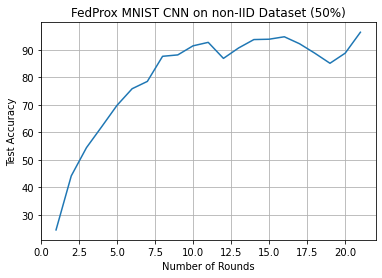

In [ ]:
## 7
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 50
# target_test_accuracy
target_test_accuracy=96.0
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_non_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN on non-IID Dataset (50%)", "green", target_test_accuracy)

**MNIST MLP on IID**

**Train**


System heterogeneity set to 50% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.592... 	Test Loss: 0.3277523251891136... 	Test Accuracy: 90.63291139240506
Round: 2... 	Average Train Loss: 0.11... 	Test Loss: 0.2815986816301942... 	Test Accuracy: 93.54430379746836
Round: 3... 	Average Train Loss: 0.08... 	Test Loss: 0.24751208222284912... 	Test Accuracy: 94.17721518987342
Training Done!


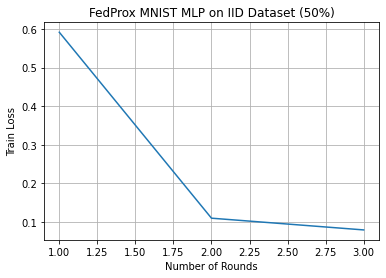

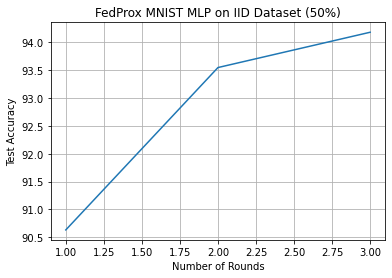

In [ ]:
## 8
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each round
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 50
# target_test_accuracy
target_test_accuracy=94.0
# dict containing different type of data partition
data_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST MLP on IID Dataset (50%)", "orange", target_test_accuracy)


**MNIST MLP on Non IID**

**Train**


System heterogeneity set to 50% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.044... 	Test Loss: 3.810183825683594... 	Test Accuracy: 16.329113924050635
Round: 2... 	Average Train Loss: 0.038... 	Test Loss: 2.830477886962891... 	Test Accuracy: 29.11392405063291
Round: 3... 	Average Train Loss: 0.028... 	Test Loss: 2.0362303070068357... 	Test Accuracy: 39.11392405063291
Round: 4... 	Average Train Loss: 0.023... 	Test Loss: 1.274211657333374... 	Test Accuracy: 55.44303797468354
Round: 5... 	Average Train Loss: 0.038... 	Test Loss: 0.9849121784210205... 	Test Accuracy: 67.9746835443038
Round: 6... 	Average Train Loss: 0.032... 	Test Loss: 1.1151309520721435... 	Test Accuracy: 65.82278481012658
Round: 7... 	Average Train Loss: 0.014... 	Test Loss: 0.8349591429710388... 	Test Accuracy: 66.20253164556962
Round: 8... 	Average Train Loss: 0.015... 	Test Loss: 0.5952024075984955... 	Test Accuracy: 77.0886075949367
Round: 9... 	Average Train Loss: 0.019...

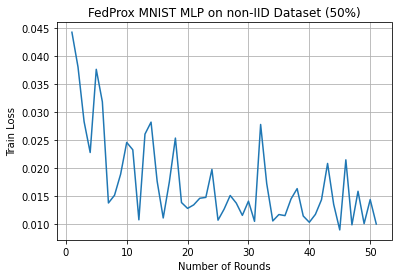

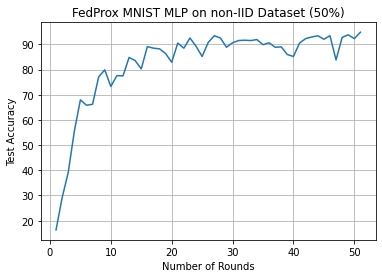

In [ ]:
## 9
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 50
# target_test_accuracy
target_test_accuracy=94.0
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_non_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST MLP on non-IID Dataset (50%)", "green", target_test_accuracy)

###### Training with 90% probability of system heterogeneity

> MNIST CNN on IID

> Train


System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.586... 	Test Loss: 0.18815626764297486... 	Test Accuracy: 94.9367088607595
Round: 2... 	Average Train Loss: 0.143... 	Test Loss: 0.11892996559590101... 	Test Accuracy: 96.70886075949367
Round: 3... 	Average Train Loss: 0.093... 	Test Loss: 0.09095747340815141... 	Test Accuracy: 97.34177215189874
Training Done!


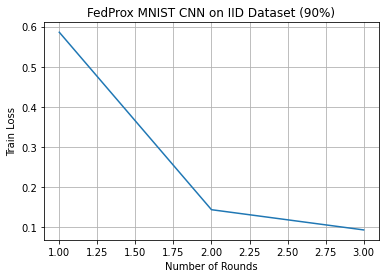

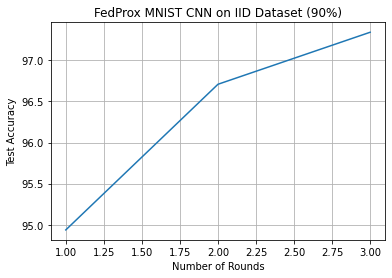

In [ ]:
## 10
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 90
# target_test_accuracy
target_test_accuracy=97.0
# data partition dictionary
iid_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, iid_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN on IID Dataset (90%)", "orange", target_test_accuracy)


****MNIST CNN on Non IID****

***Train***


System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.072... 	Test Loss: 2.0128516380310058... 	Test Accuracy: 28.860759493670887
Round: 2... 	Average Train Loss: 0.053... 	Test Loss: 1.6325313659667968... 	Test Accuracy: 39.74683544303797
Round: 3... 	Average Train Loss: 0.041... 	Test Loss: 0.8619025512695313... 	Test Accuracy: 75.69620253164557
Round: 4... 	Average Train Loss: 0.031... 	Test Loss: 0.7777048371315003... 	Test Accuracy: 74.0506329113924
Round: 5... 	Average Train Loss: 0.028... 	Test Loss: 0.541992165184021... 	Test Accuracy: 82.65822784810126
Round: 6... 	Average Train Loss: 0.022... 	Test Loss: 0.5274423846721649... 	Test Accuracy: 84.55696202531645
Round: 7... 	Average Train Loss: 0.025... 	Test Loss: 0.5771643508911133... 	Test Accuracy: 77.9746835443038
Round: 8... 	Average Train Loss: 0.023... 	Test Loss: 0.26593824002742766... 	Test Accuracy: 92.53164556962025
Round: 9... 	Average Train Loss: 0.019

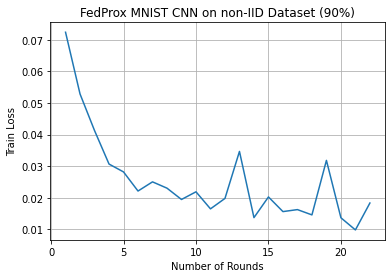

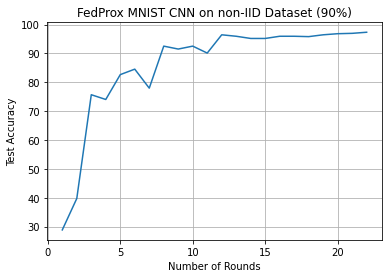

In [ ]:
## 11
# number of training rounds
rounds = 1000
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03
# target test accuracy
target_test_accuracy = 97.0
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 90
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_non_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN on non-IID Dataset (90%)", "green", target_test_accuracy)

**MNIST MLP on IID**

**Train**

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.326... 	Test Loss: 0.3428406125307083... 	Test Accuracy: 90.37974683544304
Round: 2... 	Average Train Loss: 0.207... 	Test Loss: 0.2809651076823473... 	Test Accuracy: 93.41772151898734
Round: 3... 	Average Train Loss: 0.081... 	Test Loss: 0.25782010851949455... 	Test Accuracy: 93.67088607594937
Round: 4... 	Average Train Loss: 0.086... 	Test Loss: 0.23446861448734999... 	Test Accuracy: 94.30379746835443
Training Done!


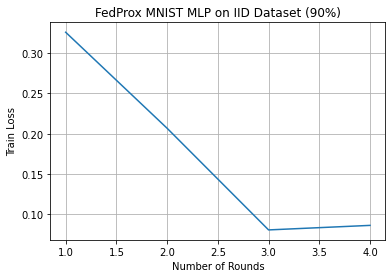

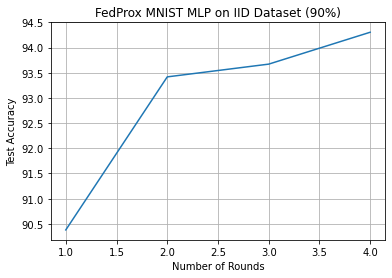

In [ ]:
## 12
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each round
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 90
# target_test_accuracy
target_test_accuracy=94.0
# dict containing different type of data partition
data_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST MLP on IID Dataset (90%)", "orange", target_test_accuracy)


**MNIST MLP on Non IID**

**Train**

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.157... 	Test Loss: 3.44962672996521... 	Test Accuracy: 37.46835443037975
Round: 2... 	Average Train Loss: 0.054... 	Test Loss: 2.3370979110717776... 	Test Accuracy: 38.35443037974684
Round: 3... 	Average Train Loss: 0.095... 	Test Loss: 1.4367593620300294... 	Test Accuracy: 59.49367088607595
Round: 4... 	Average Train Loss: 0.032... 	Test Loss: 1.4893224033355712... 	Test Accuracy: 49.11392405063291
Round: 5... 	Average Train Loss: 0.03... 	Test Loss: 1.0444198083877563... 	Test Accuracy: 61.139240506329116
Round: 6... 	Average Train Loss: 0.041... 	Test Loss: 1.258116261100769... 	Test Accuracy: 63.164556962025316
Round: 7... 	Average Train Loss: 0.027... 	Test Loss: 0.9617358926773071... 	Test Accuracy: 66.58227848101266
Round: 8... 	Average Train Loss: 0.029... 	Test Loss: 0.7401147763252258... 	Test Accuracy: 75.18987341772151
Round: 9... 	Average Train Loss: 0.034.

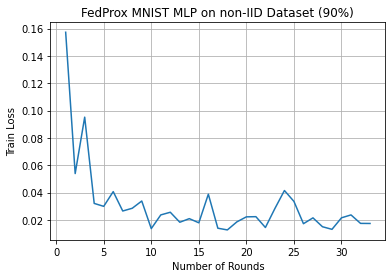

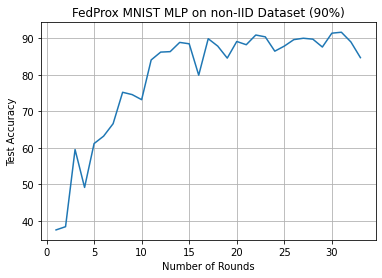

In [ ]:
## 13
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 90
# target_test_accuracy
target_test_accuracy=94.0
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_non_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST MLP on non-IID Dataset (90%)", "green", target_test_accuracy)


###### **Comparison with Federated Averaging IID Partition**

In a highly heterogenous system (90%) stragglers, authors of FedProx have claimed that FedProx achieves on average 22% improvement in testing accuracy compared to Federated Averaging

With our first test above, we know that the special case where mu=0, FedProx matches the results of FedAvg.

We will use the same idea but increase our stragglers this time. We will run the same experiment with mu > 0 to compare results of FedProx.

**Training Federated Averaging with 90% stragglers (IID Partition)**

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.139... 	Test Loss: 0.22241746542677282... 	Test Accuracy: 95.0632911392405
Round: 2... 	Average Train Loss: 0.036... 	Test Loss: 0.16327898186590756... 	Test Accuracy: 96.70886075949367
Round: 3... 	Average Train Loss: 0.027... 	Test Loss: 0.17628223571382695... 	Test Accuracy: 96.20253164556962
Round: 4... 	Average Train Loss: 0.02... 	Test Loss: 0.12001588806129293... 	Test Accuracy: 97.21518987341773
Round: 5... 	Average Train Loss: 0.015... 	Test Loss: 0.10293238678392372... 	Test Accuracy: 97.0886075949367
Round: 6... 	Average Train Loss: 0.014... 	Test Loss: 0.08943212574438766... 	Test Accuracy: 97.72151898734177
Round: 7... 	Average Train Loss: 0.015... 	Test Loss: 0.09838694761935549... 	Test Accuracy: 97.9746835443038
Round: 8... 	Average Train Loss: 0.015... 	Test Loss: 0.08715005199810294... 	Test Accuracy: 98.48101265822785
Round: 9... 	Average Train Loss: 

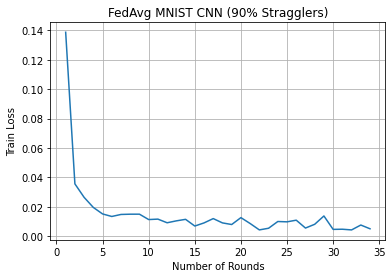

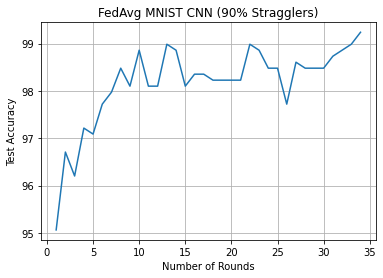

In [ ]:
## 14
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03
# proximal term constant
mu = 0.0
# percentage of clients to have fewer than E epochs
percentage = 90
# target test accuracy
target_test_accuracy = 99.0
# data partition dictionary
iid_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_iid_trained_fedavg = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, iid_dict, mnist_data_test, C, K, E, mu, percentage, "FedAvg MNIST CNN (90% Stragglers)", "orange", target_test_accuracy, algorithm='fedavg')

 **Training FedProx with 90% Stragglers (IID Parition)**

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.455... 	Test Loss: 0.15063375587761402... 	Test Accuracy: 95.9493670886076
Round: 2... 	Average Train Loss: 0.101... 	Test Loss: 0.10421379545261152... 	Test Accuracy: 96.83544303797468
Round: 3... 	Average Train Loss: 0.085... 	Test Loss: 0.08475892751037609... 	Test Accuracy: 97.0886075949367
Round: 4... 	Average Train Loss: 0.058... 	Test Loss: 0.07116736746745883... 	Test Accuracy: 98.10126582278481
Round: 5... 	Average Train Loss: 0.056... 	Test Loss: 0.06317645163832931... 	Test Accuracy: 98.10126582278481
Round: 6... 	Average Train Loss: 0.047... 	Test Loss: 0.057050456904165915... 	Test Accuracy: 98.48101265822785
Round: 7... 	Average Train Loss: 0.045... 	Test Loss: 0.05195325671324972... 	Test Accuracy: 98.22784810126582
Round: 8... 	Average Train Loss: 0.036... 	Test Loss: 0.05108136088921747... 	Test Accuracy: 98.73417721518987
Round: 9... 	Average Train Los

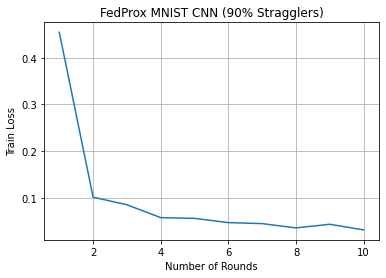

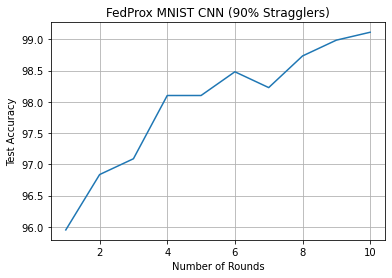

In [ ]:
## 15
# number of training rounds
rounds = 300
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 90
# target test accuracy
target_test_accuracy = 99.0

# data partition dictionary
iid_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_iid_trained_fedprox = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, iid_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN (90% Stragglers)", "green", target_test_accuracy)


###### **Comparison with Federated Averaging non-IID Partition**

In a highly heterogenous system (90%) stragglers, authors of FedProx have claimed that FedProx achieves on average 22% improvement in testing accuracy compared to Federated Averaging

With our first test above, we know that the special case where mu=0, FedProx matches the results of FedAvg.

We will use the same idea but increase our stragglers this time. We will run the same experiment with mu > 0 to compare results of FedProx.

**Training Federated Averaging with 90% stragglers (non-IID Partition)**

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.021... 	Test Loss: 10.832154949951171... 	Test Accuracy: 19.367088607594937
Round: 2... 	Average Train Loss: 0.016... 	Test Loss: 9.10940617980957... 	Test Accuracy: 21.139240506329113
Round: 3... 	Average Train Loss: 0.029... 	Test Loss: 8.929368118286133... 	Test Accuracy: 22.658227848101266
Round: 4... 	Average Train Loss: 0.022... 	Test Loss: 8.969410205078125... 	Test Accuracy: 19.240506329113924
Round: 5... 	Average Train Loss: 0.012... 	Test Loss: 9.149592459106445... 	Test Accuracy: 19.873417721518987
Round: 6... 	Average Train Loss: 0.008... 	Test Loss: 10.693393814086914... 	Test Accuracy: 18.10126582278481
Round: 7... 	Average Train Loss: 0.066... 	Test Loss: 7.130576402282715... 	Test Accuracy: 19.746835443037973
Round: 8... 	Average Train Loss: 0.022... 	Test Loss: 14.957574412536621... 	Test Accuracy: 11.265822784810126
Round: 9... 	Average Train Loss: 0.0

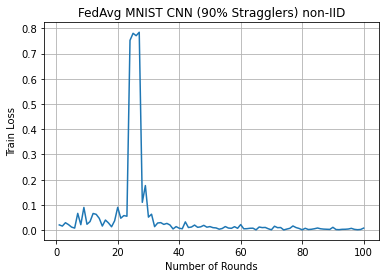

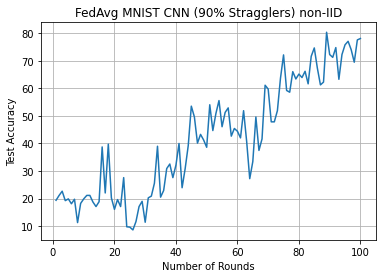

In [ ]:
## 16
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03
# proximal term constant
mu = 0.0
# percentage of clients to have fewer than E epochs
percentage = 90
# target test accuracy
target_test_accuracy = 90.0
# data partition dictionary
non_iid_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_non_iid_trained_fedavg = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, non_iid_dict, mnist_data_test, C, K, E, mu, percentage, "FedAvg MNIST CNN (90% Stragglers) non-IID", "orange", target_test_accuracy, algorithm='fedavg')

**Training FedProx with 90% Stragglers (non-IID Parition)**

System heterogeneity set to 90% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.079... 	Test Loss: 2.0260515712738036... 	Test Accuracy: 41.89873417721519
Round: 2... 	Average Train Loss: 0.054... 	Test Loss: 2.049523882675171... 	Test Accuracy: 42.40506329113924
Round: 3... 	Average Train Loss: 0.038... 	Test Loss: 1.3624716594696045... 	Test Accuracy: 56.835443037974684
Round: 4... 	Average Train Loss: 0.038... 	Test Loss: 0.7578239213943482... 	Test Accuracy: 79.62025316455696
Round: 5... 	Average Train Loss: 0.025... 	Test Loss: 0.5580435530185699... 	Test Accuracy: 85.44303797468355
Round: 6... 	Average Train Loss: 0.025... 	Test Loss: 0.4544892134666443... 	Test Accuracy: 85.56962025316456
Round: 7... 	Average Train Loss: 0.032... 	Test Loss: 0.507141660475731... 	Test Accuracy: 82.65822784810126
Round: 8... 	Average Train Loss: 0.015... 	Test Loss: 0.5338139503002167... 	Test Accuracy: 79.24050632911393
Round: 9... 	Average Train Loss: 0.019

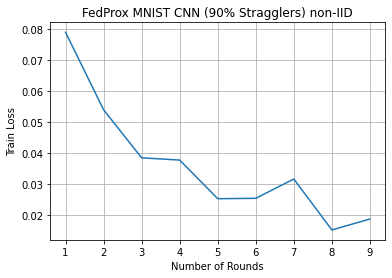

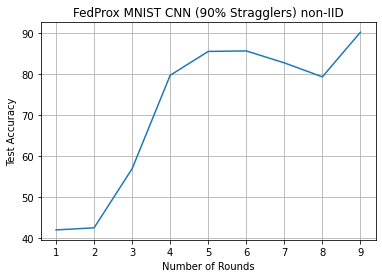

In [ ]:
## 17
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.03
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 90
# target test accuracy
target_test_accuracy = 90.0

# data partition dictionary
non_iid_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_non_iid_trained_fedprox = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, non_iid_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN (90% Stragglers) non-IID", "green", target_test_accuracy)